In [106]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import when
from pyspark.sql.functions import * 
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorSlicer,IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark import SparkFiles
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
spark = SparkSession.builder.appName('Yelp Businesses EDA').getOrCreate()
sc = spark.sparkContext 
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.metrics import classification_report, accuracy_score

In [33]:
# read data and see schema 
df = spark.read.option('multiline','true').option("quote", "\"").option('escape','\"')\
.option('ignoreLeadingWhiteSpace', 'true').option('header', True).option('escapeQuotes', 'true')\
.parquet('gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/cleansed_data/combined.snappy.parquet') 
df.printSchema() 

root
 |-- user_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- r_cool: long (nullable = true)
 |-- r_date: date (nullable = true)
 |-- r_funny: long (nullable = true)
 |-- r_stars: double (nullable = true)
 |-- r_text: string (nullable = true)
 |-- r_useful: long (nullable = true)
 |-- r_datetime: timestamp (nullable = true)
 |-- r_year: integer (nullable = true)
 |-- r_month: integer (nullable = true)
 |-- r_day: integer (nullable = true)
 |-- r_hour: integer (nullable = true)
 |-- r_text_length: integer (nullable = true)
 |-- b_address: string (nullable = true)
 |-- b_categories: string (nullable = true)
 |-- b_city: string (nullable = true)
 |-- b_is_open: long (nullable = true)
 |-- b_latitude: double (nullable = true)
 |-- b_longitude: double (nullable = true)
 |-- b_name: string (nullable = true)
 |-- b_postal_code: string (nullable = true)
 |-- b_review_count: long (nullable = true)
 |-- b_stars: double (nulla

In [34]:
column_names = [
 'r_stars',
 'b_BusinessParking_street',
 'b_Ambience_casual',
 'b_Ambience_classy',
 'b_GoodForMeal_lunch',
 'b_GoodForMeal_dinner',
 'b_Ambience_trendy',
 'b_RestaurantsDelivery',
 's_Price_total',
 's_Opinion_total',
 's_Food_total',
 's_Atmosphere_total',
 's_Service_total',
 's_Total_sentscore',
 's_Price_sentscore',
 's_Opinion_sentscore',
 's_Food_sentscore',
 's_Atmosphere_sentscore',
 's_Service_sentscore',
 's_Sentence_num']

In [56]:
df_ml = df.select(*[col(c) for c in column_names])

In [7]:
# Number of NA in each column
na_counts = df_ml.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_ml.columns])
na_counts.show()

+-------+------------------------+-----------------+-----------------+-------------------+--------------------+-----------------+---------------------+-------------+---------------+------------+------------------+---------------+-----------------+-----------------+-------------------+----------------+----------------------+-------------------+--------------+
|r_stars|b_BusinessParking_street|b_Ambience_casual|b_Ambience_classy|b_GoodForMeal_lunch|b_GoodForMeal_dinner|b_Ambience_trendy|b_RestaurantsDelivery|s_Price_total|s_Opinion_total|s_Food_total|s_Atmosphere_total|s_Service_total|s_Total_sentscore|s_Price_sentscore|s_Opinion_sentscore|s_Food_sentscore|s_Atmosphere_sentscore|s_Service_sentscore|s_Sentence_num|
+-------+------------------------+-----------------+-----------------+-------------------+--------------------+-----------------+---------------------+-------------+---------------+------------+------------------+---------------+-----------------+-----------------+-------------

In [57]:
row_counts = df_ml.count()

In [58]:
threshold = row_counts * 0.2
columns_to_drop = [c for c in na_counts.columns if na_counts.first()[c] > threshold]

In [59]:
df_ml = df_ml.drop(*columns_to_drop)

In [39]:
# Number of NA in each column
na_counts = df_ml.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_ml.columns])
na_counts.show()

+-------+------------------------+-----------------+-----------------+-------------------+--------------------+-----------------+---------------------+-------------+---------------+------------+------------------+---------------+-----------------+-----------------+-------------------+----------------+----------------------+-------------------+--------------+
|r_stars|b_BusinessParking_street|b_Ambience_casual|b_Ambience_classy|b_GoodForMeal_lunch|b_GoodForMeal_dinner|b_Ambience_trendy|b_RestaurantsDelivery|s_Price_total|s_Opinion_total|s_Food_total|s_Atmosphere_total|s_Service_total|s_Total_sentscore|s_Price_sentscore|s_Opinion_sentscore|s_Food_sentscore|s_Atmosphere_sentscore|s_Service_sentscore|s_Sentence_num|
+-------+------------------------+-----------------+-----------------+-------------------+--------------------+-----------------+---------------------+-------------+---------------+------------+------------------+---------------+-----------------+-----------------+-------------

In [60]:
df_ml = df_ml.dropna()

In [61]:
df_ml.columns

['r_stars',
 'b_BusinessParking_street',
 'b_Ambience_casual',
 'b_Ambience_classy',
 'b_GoodForMeal_dinner',
 'b_RestaurantsDelivery',
 's_Price_total',
 's_Opinion_total',
 's_Food_total',
 's_Atmosphere_total',
 's_Service_total',
 's_Total_sentscore',
 's_Price_sentscore',
 's_Opinion_sentscore',
 's_Food_sentscore',
 's_Atmosphere_sentscore',
 's_Service_sentscore',
 's_Sentence_num']

In [62]:
df_ml = df_ml.repartition(100)

In [63]:
df_ml.select('b_BusinessParking_street').distinct().show()

+------------------------+
|b_BusinessParking_street|
+------------------------+
|                   false|
|                    true|
+------------------------+



In [64]:
df_ml = df_ml.withColumn('b_BusinessParking_street', when(col('b_BusinessParking_street')=='false', -1).when(col('b_BusinessParking_street')=='true', 1).otherwise(0))

In [65]:
df_ml.select('b_BusinessParking_street').distinct().show()

+------------------------+
|b_BusinessParking_street|
+------------------------+
|                      -1|
|                       1|
+------------------------+



In [66]:
df_ml.select('b_Ambience_casual').distinct().show()

+-----------------+
|b_Ambience_casual|
+-----------------+
|            false|
|             true|
+-----------------+



In [67]:
df_ml = df_ml.withColumn('b_Ambience_casual', when(col('b_Ambience_casual')=='false', -1)\
                         .when(col('b_Ambience_casual')=='true', 1).otherwise(0))

In [68]:
df_ml.select('b_Ambience_classy').distinct().show()

+-----------------+
|b_Ambience_classy|
+-----------------+
|            false|
|             true|
+-----------------+



In [69]:
df_ml = df_ml.withColumn('b_Ambience_classy', when(col('b_Ambience_classy')=='false', -1)\
                         .when(col('b_Ambience_classy')=='true', 1).otherwise(0))

In [72]:
df_ml.select('b_GoodForMeal_dinner').distinct().show()

+--------------------+
|b_GoodForMeal_dinner|
+--------------------+
|               false|
|                true|
+--------------------+



In [73]:
df_ml = df_ml.withColumn('b_GoodForMeal_dinner', when(col('b_GoodForMeal_dinner')=='false', -1)\
                         .when(col('b_GoodForMeal_dinner')=='true', 1).otherwise(0))

In [74]:
df_ml.select('b_GoodForMeal_dinner').distinct().show()

+--------------------+
|b_GoodForMeal_dinner|
+--------------------+
|                  -1|
|                   1|
+--------------------+



In [75]:
df_ml.select('b_RestaurantsDelivery').distinct().show()

+---------------------+
|b_RestaurantsDelivery|
+---------------------+
|                False|
|              unknown|
|                 True|
+---------------------+



In [76]:
df_ml = df_ml.withColumn('b_RestaurantsDelivery', when(col('b_RestaurantsDelivery')=='False', -1)\
                         .when(col('b_RestaurantsDelivery')=='True', 1).otherwise(0))

In [77]:
df_ml.printSchema()

root
 |-- r_stars: double (nullable = true)
 |-- b_BusinessParking_street: integer (nullable = false)
 |-- b_Ambience_casual: integer (nullable = false)
 |-- b_Ambience_classy: integer (nullable = false)
 |-- b_GoodForMeal_dinner: integer (nullable = false)
 |-- b_RestaurantsDelivery: integer (nullable = false)
 |-- s_Price_total: long (nullable = true)
 |-- s_Opinion_total: long (nullable = true)
 |-- s_Food_total: long (nullable = true)
 |-- s_Atmosphere_total: long (nullable = true)
 |-- s_Service_total: long (nullable = true)
 |-- s_Total_sentscore: double (nullable = true)
 |-- s_Price_sentscore: double (nullable = true)
 |-- s_Opinion_sentscore: double (nullable = true)
 |-- s_Food_sentscore: double (nullable = true)
 |-- s_Atmosphere_sentscore: double (nullable = true)
 |-- s_Service_sentscore: double (nullable = true)
 |-- s_Sentence_num: long (nullable = true)



In [78]:
df_ml.coalesce(1).write.save("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/cleansed_data/df_mlv3", format = "parquet", overwrite=True)

In [79]:
df_ml.dtypes

[('r_stars', 'double'),
 ('b_BusinessParking_street', 'int'),
 ('b_Ambience_casual', 'int'),
 ('b_Ambience_classy', 'int'),
 ('b_GoodForMeal_dinner', 'int'),
 ('b_RestaurantsDelivery', 'int'),
 ('s_Price_total', 'bigint'),
 ('s_Opinion_total', 'bigint'),
 ('s_Food_total', 'bigint'),
 ('s_Atmosphere_total', 'bigint'),
 ('s_Service_total', 'bigint'),
 ('s_Total_sentscore', 'double'),
 ('s_Price_sentscore', 'double'),
 ('s_Opinion_sentscore', 'double'),
 ('s_Food_sentscore', 'double'),
 ('s_Atmosphere_sentscore', 'double'),
 ('s_Service_sentscore', 'double'),
 ('s_Sentence_num', 'bigint')]

In [80]:
num_var = [i[0] for i in df_ml.dtypes if ((i[1]=='bigint') | (i[1]=='double')| (i[1]=='int')| (i[1]=='double')) & (i[0]!='r_stars')]

In [7]:
df_ml.select('r_stars').distinct().show()

+-------+
|r_stars|
+-------+
|    1.0|
|    4.0|
|    3.0|
|    2.0|
|    5.0|
+-------+



In [81]:
df_ml = df_ml.repartition(100)

In [82]:
df_ml = df_ml.withColumn('r_stars', 
                         when(col('r_stars')== 5.0, 'High')\
                         .when(col('r_stars')== 4.0, 'High')\
                         .when(col('r_stars')== 3.0, 'High')\
                         .otherwise('Low'))

In [83]:
df_ml.select('r_stars').distinct().show()

+-------+
|r_stars|
+-------+
|   High|
|    Low|
+-------+



In [84]:
train_df, test_df = df_ml.randomSplit([.8,.2],seed=1234)

In [ ]:
label_indexes = StringIndexer(inputCol = 'r_stars', outputCol = 'label', handleInvalid = 'keep')
assembler = VectorAssembler(inputCols = num_var , outputCol = "features")

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create ParamGrid
paramGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.maxBins, [5, 10, 20])
               .addGrid(rf.numTrees, [5, 20, 50])
             .build())
pipeline = Pipeline(stages=[assembler, label_indexes, rf])

# Create cross validator
cv_rf = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)

# Run cross validations.
cv_model_rf = cv_rf.fit(train_df)


23/05/19 01:19:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1714.8 KiB
23/05/19 01:19:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.1 MiB
23/05/19 01:19:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1399.6 KiB
23/05/19 01:20:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1110.0 KiB
23/05/19 01:20:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/05/19 01:20:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/05/19 01:20:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1199.3 KiB
23/05/19 01:20:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 7.7 MiB
23/05/19 01:21:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large t

In [ ]:
bestmodel = cv_model_rf.bestModel

In [ ]:
cv_model_rf.write().save("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/model/RF_cv2")

In [ ]:
# cvModelRead = CrossValidatorModel.read().load(model_path)

In [29]:
bestmodel.stages

[VectorAssembler_abbe411b963d,
 StringIndexerModel: uid=StringIndexer_4be342c4f622, handleInvalid=keep,
 RandomForestClassificationModel: uid=RandomForestClassifier_5cd88a342780, numTrees=50, numClasses=3, numFeatures=20]

In [ ]:
# to masure the accuracy, use the test set.
predictions = cv_model_rf.transform(test_df)

In [ ]:
predictions.coalesce(1).write.save("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/ML_Result/RF2", format = "parquet", overwrite=True)

23/05/19 02:06:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


In [ ]:
import pandas as pd

In [145]:
feature_lst = []
imp_lst = []
for i in range(len(predictions.schema['features'].metadata['ml_attr']['attrs']['numeric'])):
    feature_lst.append(predictions.schema['features'].metadata['ml_attr']['attrs']['numeric'][i]['name'])
    imp_lst.append(bestmodel.stages[2].featureImportances[i])

In [147]:
pd.DataFrame({'feature':feature_lst,
             'importance':imp_lst}).sort_values(by='importance', ascending=False)

,feature,importance
10,s_Total_sentscore,0.550959
15,s_Service_sentscore,0.175018
13,s_Food_sentscore,0.166216
12,s_Opinion_sentscore,0.044330
14,s_Atmosphere_sentscore,0.018770
9,s_Service_total,0.013861
11,s_Price_sentscore,0.012597
7,s_Food_total,0.008590
16,s_Sentence_num,0.002307
0,b_BusinessParking_street,0.001958


In [150]:
importances = pd.DataFrame({'feature':feature_lst,
             'importance':imp_lst}).sort_values(by='importance', ascending=False)

<AxesSubplot:ylabel='feature'>

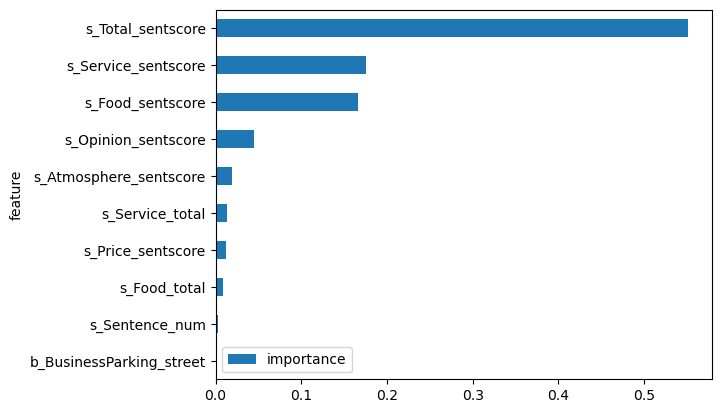

In [152]:
importances.set_index('feature').head(10).sort_values(by='importance').plot.barh()

In [ ]:
evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

23/05/19 02:06:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.9073238758955622

In [ ]:
evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

23/05/19 02:06:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.9065582032245225

In [114]:
# Un-index the data so we have the species names rather than the index numbers in our output.
converter = IndexToString(inputCol="prediction", outputCol="PredictedLabel", labels=bestmodel.stages[1].labels)
converted = converter.transform(predictions)

In [112]:
bestmodel.stages[1].labels

['High', 'Low']

In [121]:
# precision Forecast: High -> True: High
t_p = converted.filter(col('PredictedLabel')=='High').filter(col('r_stars')=='High').count()
f_p = converted.filter(col('PredictedLabel')=='High').filter(col('r_stars')!='High').count()
precision = t_p / (t_p + f_p)
precision

23/05/19 05:06:14 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/05/19 05:06:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.9389613417259774

In [122]:
# precision Forecast: Low -> True: Low
t_p = converted.filter(col('PredictedLabel')=='Low').filter(col('r_stars')=='Low').count()
f_p = converted.filter(col('PredictedLabel')=='Low').filter(col('r_stars')!='Low').count()
precision = t_p / (t_p + f_p)
precision

23/05/19 05:06:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/05/19 05:06:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.760910494806541

In [123]:
# Recall True: High -> Forecast：High
t_p = converted.filter(col('PredictedLabel')=='High').filter(col('r_stars')=='High').count()
f_n = converted.filter(col('PredictedLabel')!='High').filter(col('r_stars')=='High').count()
recall = t_p / (t_p + f_n)
recall

23/05/19 05:10:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/05/19 05:10:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.9478478349145409

In [124]:
# Recall True: Low -> Forecast：Low
t_p = converted.filter(col('PredictedLabel')=='Low').filter(col('r_stars')=='Low').count()
f_n = converted.filter(col('PredictedLabel')!='Low').filter(col('r_stars')=='Low').count()
recall = t_p / (t_p + f_n)
recall

23/05/19 05:10:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/05/19 05:10:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


0.7292688860954544

In [115]:
df = converted.select('r_stars', 'PredictedLabel').toPandas()

print('Random ForestConfusion matrix')
print(classification_report(df.r_stars, df.PredictedLabel))

23/05/19 04:56:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


Random ForestConfusion matrix
              precision    recall  f1-score   support

        High       0.94      0.95      0.94    433424
         Low       0.76      0.73      0.74     98644

    accuracy                           0.91    532068
   macro avg       0.85      0.84      0.84    532068
weighted avg       0.91      0.91      0.91    532068



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
label_indexes = StringIndexer(inputCol = 'r_stars', outputCol = 'label', handleInvalid = 'keep')
assembler = VectorAssembler(inputCols = num_var , outputCol = "features")

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create ParamGrid
dtparamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(dt.maxBins, [10, 20, 40, 80, 100])
             .build())
pipeline = Pipeline(stages=[assembler, label_indexes, dt])

# Create cross validator
cv_dt = CrossValidator(estimator = pipeline,
                      estimatorParamMaps = paramGrid,
                      evaluator = evaluator,
                      numFolds = 5)

# Run cross validations.
cv_model_dt = cv_dt.fit(train_df)
print(cv_model_dt)
# to masure the accuracy, use the test set.
predictions_dt = cv_model_dt.transform(test_df)

CrossValidatorModel_03ce02b18227


In [ ]:
evaluator.evaluate(predictions_dt, {evaluator.metricName: "accuracy"})

0.9062488253381147

In [ ]:
evaluator.evaluate(predictions_dt, {evaluator.metricName: "f1"})

0.9052372736079134

In [ ]:
predictions_dt.coalesce(1).write.save("gs://msca-bdp-student-gcs/GroupProject_Gr7/yelp_dataset/ML_Result/DT2", format = "parquet", overwrite=True)

In [116]:
converted_dt = converter.transform(predictions_dt)

In [125]:
# precision Forecast: High -> True: High
t_p = converted_dt.filter(col('PredictedLabel')=='High').filter(col('r_stars')=='High').count()
f_p = converted_dt.filter(col('PredictedLabel')=='High').filter(col('r_stars')!='High').count()
precision = t_p / (t_p + f_p)
precision

0.9370988475985559

In [126]:
# precision Forecast: Low -> True: Low
t_p = converted_dt.filter(col('PredictedLabel')=='Low').filter(col('r_stars')=='Low').count()
f_p = converted_dt.filter(col('PredictedLabel')=='Low').filter(col('r_stars')!='Low').count()
precision = t_p / (t_p + f_p)
precision

0.7612287318390263

In [127]:
# Recall True: High -> Forecast：High
t_p = converted_dt.filter(col('PredictedLabel')=='High').filter(col('r_stars')=='High').count()
f_n = converted_dt.filter(col('PredictedLabel')!='High').filter(col('r_stars')=='High').count()
recall = t_p / (t_p + f_n)
recall

0.9485838347668796

In [128]:
# Recall True: Low -> Forecast：Low
t_p = converted_dt.filter(col('PredictedLabel')=='Low').filter(col('r_stars')=='Low').count()
f_n = converted_dt.filter(col('PredictedLabel')!='Low').filter(col('r_stars')=='Low').count()
recall = t_p / (t_p + f_n)
recall

0.7202364056607599

In [118]:
df = converted_dt.select('r_stars', 'PredictedLabel').toPandas()

print('Random ForestConfusion matrix')
print(classification_report(df.r_stars, df.PredictedLabel))

Random ForestConfusion matrix
              precision    recall  f1-score   support

        High       0.94      0.95      0.94    433424
         Low       0.76      0.72      0.74     98644

    accuracy                           0.91    532068
   macro avg       0.85      0.83      0.84    532068
weighted avg       0.90      0.91      0.91    532068

